In [11]:
# Measurement Function, here one should consider that the number of sensor can be arrenged dynamically 
# but it should be square number like 4,9,36
def h(x_t):
    z_t = np.zeros(len(sensor_coords))
    for i, (x_i, y_i) in enumerate(sensor_coords):
        d_i_t = sqrt((x_i - x_t[0])**2 + (y_i - x_t[1])**2)
        z_t[i] = sqrt(P0 / (1 + d_i_t**n))
    return z_t


In [12]:
# Jacobian of measurement vector
# used because our measurement is nonlinear and we use derivation to make it similar to linear
def HJacobian_at(x):
    Xt, Yt = x[0], x[1]  # Target's position
    H = np.zeros((len(sensor_coords), 4))
    for i, sensor_coord in enumerate(sensor_coords):
        x_sensor, y_sensor = sensor_coord
        denominator = ((x_sensor - Xt)**2 + (y_sensor - Yt)**2 + 1)
        v1 = sqrt(P0 / denominator) * (x_sensor - Xt) / denominator
        v2 = sqrt(P0 / denominator) * (y_sensor - Yt) / denominator
        H[i] = [v1, v2, 0, 0]
    return H

In [13]:
import numpy as np
# how does sensor located here it is 10 cm apart each other and there is 6 X 6 = 36 sensors
P0 = 1000
n = 2
sensor_coords = np.array([[x, y] for x in range(6) for y in range(6)]) * (10.0)

In [14]:
import numpy as np
## Classic predict and update function in Extended Kalman Filter
def predict(x, P, F, Q, B=None, u=None):
    x = F @ x if u is None else F @ x + B @ u
    P = F @ P @ F.T + Q
    return x, P

def update(x, P, z, H_jac, h, R):
    H = H_jac(x)
    y = z - h(x)  # Innovation or measurement residual
    S = H @ P @ H.T + R  # Innovation covariance
    K = P @ H.T @ np.linalg.inv(S)  # Kalman gain
    x = x + K @ y  # State update
    P = P - K @ H @ P  # Covariance update
    return x, P

In [15]:
x_mean = np.array([5, 5, 4, 4])
p_varience = np.diag([2.778, 2.778, 0.01, 0.01])
position = np.random.multivariate_normal(x_mean, p_varience)
# this is true target defined to identify whether object tracking is good or bad

## Those are parameters which define our state and also noises for both state and measurement noise

In [18]:
import numpy as np
from math import sqrt
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise


# Constants
R_std = 1
to=1e-2
dt = 0.5
num_sensors = 36

x = np.array([5, 5, 4, 4])  # Initial state
P =  np.diag([2.778, 2.778, 0.01, 0.01])  # Initial state covariance

F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]]) # State Dimension

Q = np.array ([[((dt**3)/3), 0, ((dt**2)/2), 0],
           [0, ((dt**3)/3), 0, ((dt**2)/2)],
           [((dt**2)/2), 0 , dt, 0],
           [0, ((dt**2)/2), 0 , dt]])  
Q_std = to* Q # Process Noise

R = np.eye(num_sensors) * R_std**2  # Measurement noise


# Simulation parameters
total_time = 20
T = total_time

## Where the object tracking happened within the for loop using the necessary functions. 

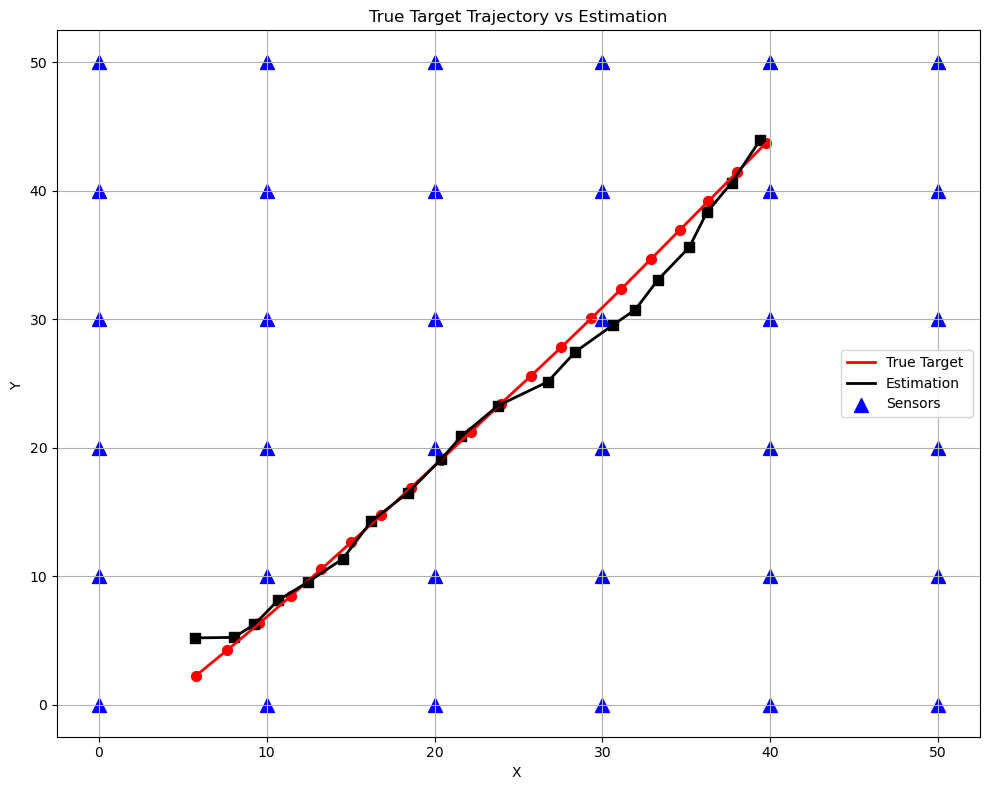

In [16]:
true_targets = np.zeros((4, T))
measurements = np.zeros((num_sensors, T))

mu = np.zeros((4, T))
# Simulate target movement and sensor measurements
for t in range(T):
    if t == 0:
        true_targets[:, t] = position # ilk deger verilir bunun üzerine tahminleme yapılır
    else:
        true_targets[:, t] = F @ true_targets[:, t-1] + np.random.multivariate_normal(np.zeros(4), Q_std)

    measurements[:, t] = h(true_targets[:, t]) + np.random.multivariate_normal(np.zeros(num_sensors), R)


    x, P = predict(x, P, F, Q)

    # Update step
    x, P = update(x, P, measurements[:, t], HJacobian_at, h ,R)      
    mu[:, t] = x.ravel()
plt.figure(figsize=(10, 8));
plt.plot(true_targets[0, :], true_targets[1, :], 'r-', label='True Target ', linewidth=2)
plt.scatter(true_targets[0, :], true_targets[1, :], color='r', s=50)
plt.plot(mu[0, :], mu[1, :], 'k-', label='Estimation', linewidth=2)
plt.scatter(mu[0, :], mu[1, :], color='k', marker='s', s=50)
plt.scatter(sensor_coords[:, 0], sensor_coords[:, 1], c='blue', marker='^', s=100, label='Sensors')


plt.title("True Target Trajectory vs Estimation")
plt.xlabel("X ")
plt.ylabel("Y ")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

### MSE Error Calculated over 100 run for each tracking scenerio. 

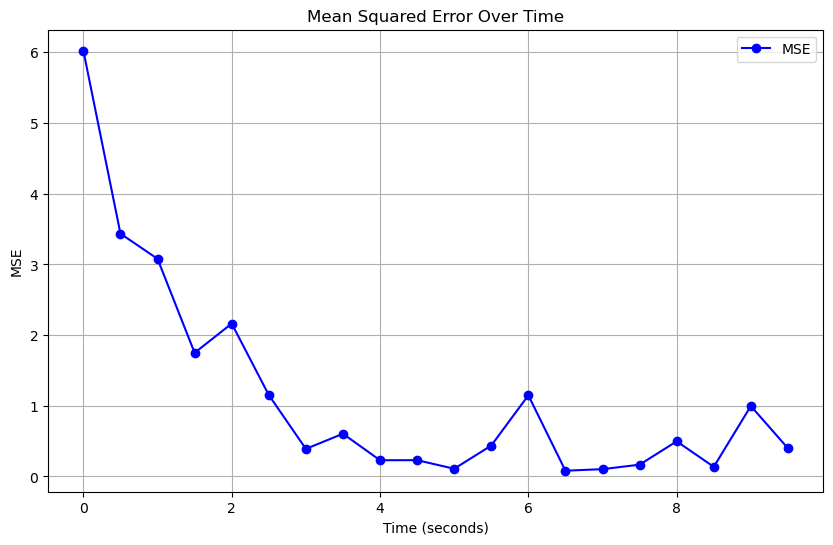

In [22]:
# Simulation
total_time = 20
runs = 100
mse_per_run = np.zeros((runs, total_time))
for run in range(runs):
    true_targets = np.zeros((4, total_time))
    measurements = np.zeros((num_sensors, total_time))
    mu = np.zeros((4, total_time))
    x = np.array([5, 5.1 , 2, 2])  # Reset state

    for t in range(total_time):
        if t == 0:
            true_targets[:, t] = position
        else:
            true_targets[:, t] = F @ true_targets[:, t-1] + np.random.multivariate_normal(np.zeros(4), Q)

        measurements[:, t] = h(true_targets[:, t]) + np.random.multivariate_normal(np.zeros(num_sensors), R)

        x, P = predict(x, P, F, Q)
        x, P = update(x, P, measurements[:, t], HJacobian_at, h, R)
        mu[:, t] = x

        mse_per_run[run, t] = np.mean((mu[:, t] - true_targets[:, t])**2)
    
timesteps = np.arange(total_time) * dt
#average_mse = np.mean(mse_per_run, axis=0) this block 
std_mse = np.std(mse_per_run, axis=0)

# Plotting the MSE with connecting lines only (no error bars)
plt.figure(figsize=(10, 6))
plt.plot(timesteps, mse_per_run[0], '-o', color='blue', label='MSE')
plt.xlabel('Time (seconds)')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

